<a href="https://colab.research.google.com/github/rushirajsherlocked/Awesome-PyTorch/blob/master/TensorBoard%2C_Save_%26_Load_Checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# TODO 1: Dataset

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)

In [ ]:
transforms_lenet = transforms.Compose([transforms.ToTensor()])     # CIFAR-10 already has 32 X 32 size images

train_dataset = datasets.CIFAR10(root='/content/data',
                                 train=True,
                                 download=True,
                                 transform = transforms_lenet)

valid_dataset = datasets.CIFAR10(root = '/content/data',
                                train=False,
                                transform = transforms_lenet)



Extracting /content/data/cifar-10-python.tar.gz to /content/data


## Convert it to DataLoader

In [ ]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset,batch_size = BATCH_SIZE, shuffle = True)

valid_loader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = True)

# TODO 2: Plot the Dataset

Text(0.5, 0.98, 'CIFAR-10 Dataset preview')

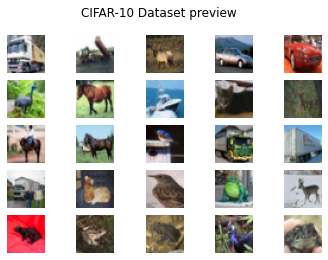

In [ ]:
ROW_IMG = 5
N_ROWS = 5

fig = plt.figure()

for index in range(1, N_ROWS*ROW_IMG + 1): # +1 for the 25th item
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index])
fig.suptitle('CIFAR-10 Dataset preview')

# TODO 3- Helpfer Functions

In [ ]:
# JUST FOR DETAILED EXPLANATION, See the CONCISE VERSION below


'''
STEPS : Load the dataloader,
        Move X and y to the "device"
        Calculate PROBABILITIES as output
        Calculate PREDICTED LABEL
        Compare PREDICTED label and  --> number of correct preds
        END of for loop

      Divide TOTAL_CORRECT / TOTAL_EXAMPLES and return it
'''


def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of predictions over the entire dataloader
    '''

    correct_preds = 0
    total_num = 0

    with torch.no_grad():
        model.eval()

        for X,y_true in data_loader: # DataLoader returns batches of size 32

            X = X.to(device)
            y_true = y_true.to(device)

            y_prob = model(X) # model(x) returns a tensor of size (BATCH_SIZE, NUM_CLASSES) - tensor([32,10])
            _, predicted_labels = torch.max(y_prob, dim=1)

            total_num += y_true.size(0)
            correct_preds += (predicted_labels == y_true).sum()

        return correct_preds.float() / total_num


In [ ]:


def calculate_accuracy(preds,labels):
    return preds.argmax(dim = 1).eq(labels).sum()




In [ ]:
def plot_losses(train_losses, valid_losses):
    '''
    Function to plot losses
    '''
    # temporarily change the style of plots to seaborn
    plt.style.use('seaborn')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color = 'blue', label = 'Trainining loss' )
    ax.plot(valid_losses, color = 'red', label = 'Validation loss')

    ax.set(title = 'Loss over epcohs', xlabel = 'epochs', ylabel = 'loss')
    ax.legend()
    fig.show()

    # change style to default
    plt.style.use('default') 

# TODO 4: Training Functions

In [ ]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training pass of the training
    '''
    model.train()
    running_loss = 0
    epoch_acc = 0

    for X, y_true in train_loader:

        X = X.to(device)
        y_true = y_true.to(device)

        preds = model(X)

        loss = criterion(preds, y_true)

        acc = calculate_accuracy(preds, y_true)
        epoch_acc += acc.item()
        
        '''
        V.V.IMP: https://stackoverflow.com/questions/61092523/what-is-running-loss-in-pytorch-and-how-is-it-calculated#:~:text=item()%20contains%20the%20loss,batch%20size%2C%20given%20by%20inputs.
        Check the abve link for reference understanding

        # if the batch_size is 4, loss.item() would give the loss for the entire set of 4 images
        That depends on how the loss is calculated. Remember, loss is a tensor just like every other tensor. 
        In general the PyTorch APIs return avg loss by default
        "The losses are averaged across observations for each minibatch."
        '''

        # Backward pass
        loss.backward()
        optimizer.step()

        optimizer.zero_grad()

        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    return model, optimizer, epoch_loss, epoch_acc / len(train_loader.dataset)


In [ ]:
def validate(valid_loader, model, criterion, optimizer, device):
    '''
    Function for validation pass of the training
    '''
    model.eval()
    running_loss = 0
    epoch_acc = 0

    for X, y_true in valid_loader:

        X = X.to(device)
        y_true = y_true.to(device)

        preds = model(X)

        loss = criterion(preds, y_true)
        running_loss += loss.item() * X.size(0)

        acc = calculate_accuracy(preds, y_true)
        epoch_acc += acc.item()

    epoch_loss = running_loss / len(valid_loader.dataset)
    
    return model, epoch_loss, epoch_acc / len(valid_loader.dataset)

## Save model checkpoint

In [ ]:
def save_checkpoint(state, filename = 'my_checkpoint.pth'):
    print("==> Saving Checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint):
    print("==> Loading Model")
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    

In [ ]:
load_model = False

if load_model:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"))

## Training loop

In [ ]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader,
                  epochs, device, save_filename, load_filename, 
                  load_model = False, print_every = 1):
  
    '''
    Function defining the entire training loop
    '''
    if load_model:
        load_checkpoint(torch.load(load_filename))

    train_losses = []
    valid_losses = []

    best_valid_loss = float('Inf')

    # Train the model
    for epoch in range(epochs):

        checkpoint = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
        
        # if epoch % 2 == 0:
        #     checkpoint = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
        #     save_checkpoint(checkpoint, filename = save_filename)

        # Training
        model, optimizer, train_loss, train_acc = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # Validation
        with torch.no_grad():
            model, valid_loss, valid_acc = validate(valid_loader, model, criterion, optimizer, device)
            valid_losses.append(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            print("==> Found less Valid Loss, Saving Model")
            save_checkpoint(checkpoint, filename = save_filename)


        if epoch % print_every == 0:

            # train_accuracy = get_accuracy(model, train_loader, device=device)
            # valid_accuracy = get_accuracy(model, valid_loader, device=device)

            print(f'{datetime.now().time().replace(microsecond=0)}---'
                f'Epoch: {epoch}\t'
                f'Train Loss:{train_loss:.2f}\t\t'
                f'Valid Loss:{valid_loss:.2f}\t\t'
                f'Train accuracy:{100 * train_acc:.4f}\t\t'
                f'Valid accuracy:{100 * valid_acc:.4f}\t\t')
            
    plot_losses(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)



# TODO 5: Implement VGG Architecture

In [ ]:
 VGG_16 = [64,64, 'M', 128, 128, 'M', 256,256,256, 'M', 512,512,512, 'M', 512,512,512, 'M']

# Then flatten and 3 hidden layers of input_features 4096, 4096 and 1000 respectively


VGG_types = {
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG16": [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"],
    "VGG19": [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"]
            }

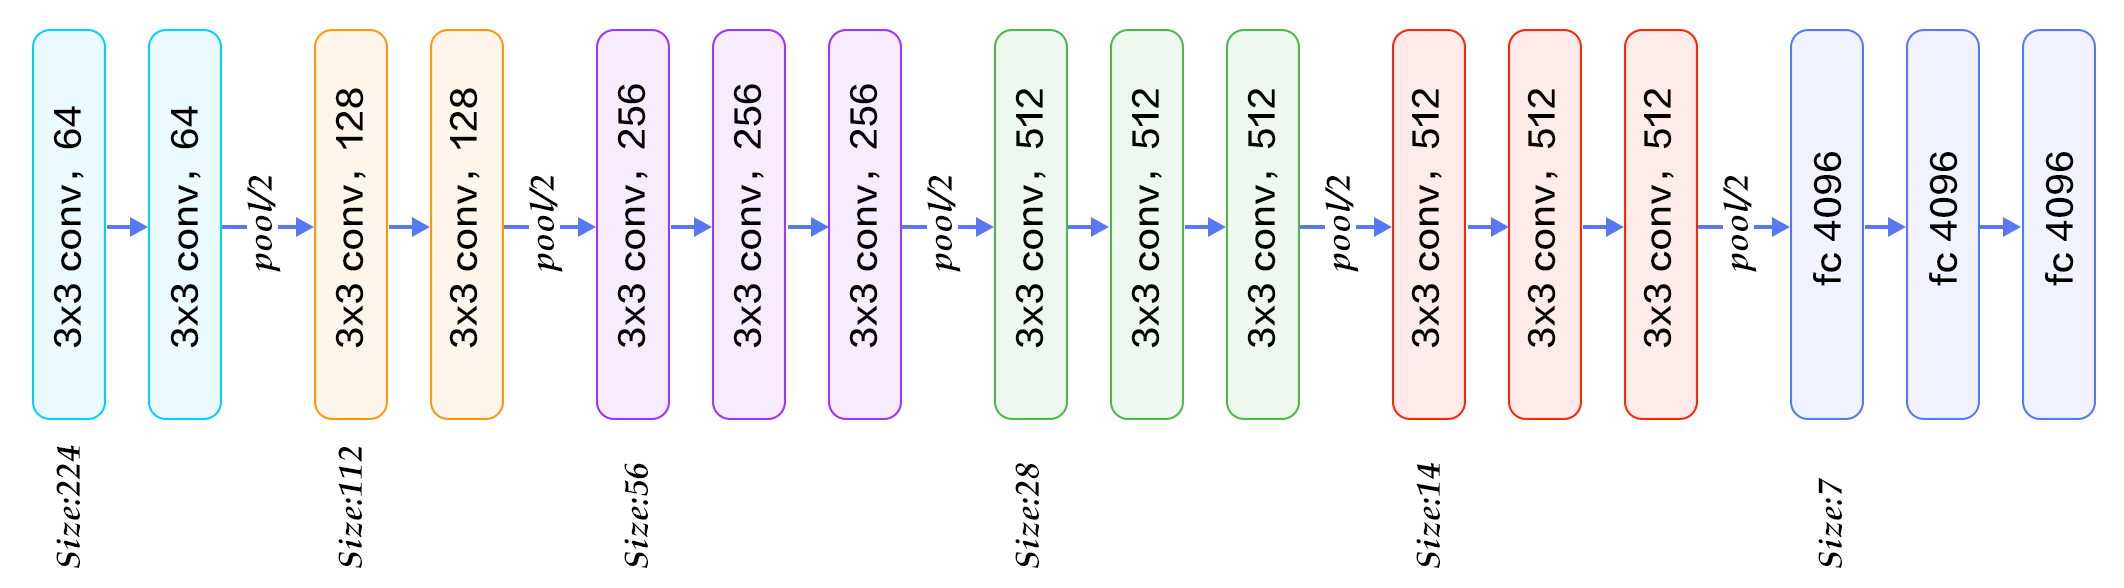

In [ ]:
 VGG_16 = [64,64, 'M', 128, 128, 'M', 256,256,256, 'M', 512,512,512, 'M', 512,512,512, 'M']

class VGG_Net(nn.Module):
    def __init__(self, in_channels = 3, num_classes = 1000):
        super(VGG_Net, self).__init__()

        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG_types['VGG16'])

        self.classifier = nn.Sequential(
            nn.Linear(512*1*1, 4096), # 1X1 because our input image size is 32 X 32 NOT (224 X 224) as the orig Res Paper
            nn.ReLU(),                # so  32 / 2**5 = 1 ( 5 MaxPool layers stride = 2 which HALVE your input image size)
            nn.Dropout(0.5),

            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(4096, num_classes)

        )


    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)

        return x

    def create_conv_layers(self, architecture):

        layers = []
        in_channels = self.in_channels

        for x in architecture:

            assert x == 'M' or isinstance(x, int)
  
            if type(x) == int:
                out_channels = x

                layers += [nn.Conv2d(in_channels = in_channels, out_channels = out_channels,
                                    kernel_size = 3, stride = 1, padding = 1),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]

                in_channels = x
            
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size = 2, stride = 2)]

        return nn.Sequential(*layers)

# Start Training

In [ ]:
# Testing

model = VGG_Net(3,1000).to(device)
x = torch.randn(1,3,32,32).to(device) # N x C x H x W format in PyTorch
print(model(x).shape)

torch.Size([1, 1000])


In [ ]:
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 64
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

==> Found less Valid Loss, Saving Model
==> Saving Checkpoint
08:22:58---Epoch: 0	Train Loss:2.07		Valid Loss:1.93		Train accuracy:16.9480		Valid accuracy:20.2700		
==> Found less Valid Loss, Saving Model
==> Saving Checkpoint
08:24:05---Epoch: 1	Train Loss:1.92		Valid Loss:1.86		Train accuracy:21.3240		Valid accuracy:22.9300		
==> Found less Valid Loss, Saving Model
==> Saving Checkpoint
08:25:13---Epoch: 2	Train Loss:1.80		Valid Loss:1.73		Train accuracy:27.0940		Valid accuracy:28.0700		
==> Found less Valid Loss, Saving Model
==> Saving Checkpoint
08:26:21---Epoch: 3	Train Loss:1.58		Valid Loss:1.35		Train accuracy:36.9400		Valid accuracy:49.0400		
==> Found less Valid Loss, Saving Model
==> Saving Checkpoint
08:27:29---Epoch: 4	Train Loss:1.33		Valid Loss:1.15		Train accuracy:48.1740		Valid accuracy:55.5500		
==> Found less Valid Loss, Saving Model
==> Saving Checkpoint
08:28:38---Epoch: 5	Train Loss:1.15		Valid Loss:0.98		Train accuracy:57.1380		Valid accuracy:65.7100		
08:29:45--

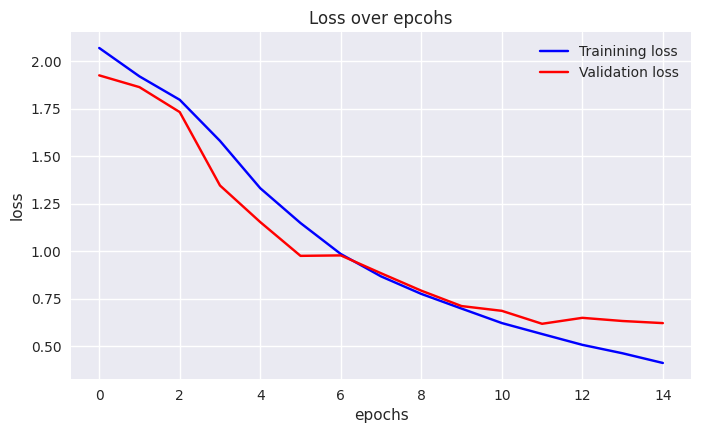

In [ ]:

torch.manual_seed(RANDOM_SEED)

model = VGG_Net(3, N_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, 
                                    valid_loader, N_EPOCHS, device, "test_model.pth",
                                    None, False) 



#      If you want to LOAD your own VGG model (trained in the way defined above) use this:



# model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, 
#                                     valid_loader, N_EPOCHS, device, "test_model.pth",
#                                     "PATH_TO_YOUR_MODEL", True) 



## Optional Weight Initialisation Note

In [ ]:
def initialize_parameters(m):
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
      nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.xavier_normal_(m.weight.data, gain = nn.init.calculate_gain('relu'))
      nn.init.constant_(m.bias.data, 0)



# NOTE: By default PyTorch uses Kaiming Initialisation you can change it to wahtever you want

# Reference: https://pytorch.org/docs/stable/nn.init.html 

In [ ]:
model.apply(initialize_parameters)

# TensorBoard

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('/content/runs/CIFAR-10')


## Writing Tensorboard

In [ ]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
import matplotlib.pyplot as plt

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
import torchvision

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid)

# write to tensorboard
writer.add_image('CIFAR-10 Images', img_grid)

In [ ]:
%load_ext tensorboard

%tensorboard --logdir /content/runs 


## Inspect the model using Tensorboard

In [ ]:
writer.add_graph(model, images.to(device))
writer.close()

## Adding a "Projector" to Tensorboard

In [ ]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    print("PERM:", perm)
    return data[perm][:n], labels[perm]

# select random images and their target indices
images, labels = select_n_random(train_dataset.data, train_dataset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 32 * 32)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

In [ ]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    print("PERM:", perm, len(perm))
    return data[perm][:n]

# select random images and their target indices
images2 = select_n_random(train_dataset.data, train_dataset.targets)
images2.dtype

In [ ]:
subset_idx = torch.cat((torch.arange(100), torch.arange(0, 0)))
subset_idx 

In [ ]:
# images, labels = train_dataset.data[subset_idx], train_dataset.targets[subset_idx[1]]

In [ ]:
images = train_dataset.data[subset_idx]
len(images)


In [ ]:
labels = []

for i in subset_idx:
    labels.append(train_dataset.targets[subset_idx[i]])

In [ ]:
labels = torch.tensor(labels)
labels.dtype
labels

In [ ]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
           'horse', 'ship', 'truck')



In [ ]:
# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view()
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(-1))
writer.close()

In [ ]:
images.view()

In [ ]:
# torch.manual_seed(RANDOM_SEED)

# model = VGG_Net(3, N_CLASSES).to(device)
# optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
# criterion = nn.CrossEntropyLoss()

# model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, 
#                                     valid_loader, N_EPOCHS, device, "test_model2.pth",
#                                     None, False) 


In [ ]:

torch.manual_seed(RANDOM_SEED)

model = VGG_Net(3, N_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, 
                                    valid_loader, N_EPOCHS, device, "test_model.pth",
                                    None, False) 



#      If you want to LOAD your own VGG model (trained in the way defined above) use this:



# model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, 
#                                     valid_loader, N_EPOCHS, device, "test_model.pth",
#                                     "PATH_TO_YOUR_MODEL", True) 

